In [1]:
from dinosaur.xarray_utils import data_to_xarray
from dinosaur import primitive_equations as pe
from dinosaur import primitive_equations_states as pes
from dinosaur import spherical_harmonic as sh
from dinosaur.scales import units

from jcm.model import SpeedyModel

import numpy as np
import jax

jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan


In [2]:
model = SpeedyModel(time_step=120, save_interval=1, total_time=1, layers=7)

state = model.get_initial_state()

final_state, predictions = model.unroll(state)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
preds = predictions['dynamics']

u_nodal, v_nodal = sh.vor_div_to_uv_nodal(model.coords.horizontal, preds.vorticity, preds.divergence)

# This doesn't currently work for predictions because of the explicit padding shape in there
# w_nodal = -pe.compute_vertical_velocity(predictions, coords)

nodal_predictions = pe.compute_diagnostic_state(preds, model.coords)


In [7]:
# Do the unit conversion before converting to xarray
t_ref = 288 #K
nodal_predictions.temperature_variation = t_ref + model.physics_specs.dimensionalize(preds.temperature_variation, units.kelvin).m

nodal_predictions.tracers['specific_humidity'] = model.physics_specs.dimensionalize(preds.tracers['specific_humidity'], units.gram / units.kilogram).m

In [8]:
broken_keys = ['cos_lat_u', 'cos_lat_grad_log_sp', 'cos_lat_grad_log_sp', ] # These are tuples which are not supported by xarray
broken_keys += ['sigma_dot_explicit', 'sigma_dot_full'] # These only have four time steps for some reason...
pred_ds = data_to_xarray({k: v for k, v in preds.asdict().items() if k not in broken_keys}, 
                         coords=model.coords, times=model.times)

pred_ds = pred_ds.rename_vars({'temperature_variation': 'temperature'})

# Skip this for now
# log_surface_pressure_nodal = coords.horizontal.to_nodal(final_state.log_surface_pressure)
# surface_pressure_nodal = np.exp(log_surface_pressure_nodal) * 1e5

pred_ds['u'] = data_to_xarray({'u': model.physics_specs.dimensionalize(np.asarray(u_nodal), units.meter / units.second).m}, coords=model.coords, times=model.times)['u']
pred_ds['v'] = data_to_xarray({'v': model.physics_specs.dimensionalize(np.asarray(v_nodal), units.meter / units.second).m}, coords=model.coords, times=model.times)['v']

# Flip the vertical dimension so that it goes from the surface to the top of the atmosphere
pred_ds = pred_ds.isel(level=slice(None, None, -1))

pred_ds

<xarray.Dataset> Size: 895kB
Dimensions:               (time: 1, level: 7, longitudinal_mode: 85,
                           total_wavenumber: 44, surface: 1, lon: 128, lat: 64)
Coordinates:
  * longitudinal_mode     (longitudinal_mode) int64 680B 0 1 -1 2 ... -41 42 -42
  * total_wavenumber      (total_wavenumber) int64 352B 0 1 2 3 ... 40 41 42 43
  * level                 (level) float64 56B 0.9286 0.7857 ... 0.2143 0.07143
  * surface               (surface) float64 8B 1.0
  * time                  (time) int32 4B 1
  * lon                   (lon) float64 1kB 0.0 2.812 5.625 ... 354.4 357.2
  * lat                   (lat) float64 512B -87.86 -85.1 -82.31 ... 85.1 87.86
Data variables:
    vorticity             (time, level, longitudinal_mode, total_wavenumber) float32 105kB ...
    log_surface_pressure  (time, surface, longitudinal_mode, total_wavenumber) float32 15kB ...
    sim_time              (time) float32 4B ...
    temperature           (time, level, longitudinal_mode, total_wavenumber) float32 105kB ...
    divergence            (time, level, longitudinal_mode, total_wavenumber) float32 105kB ...
    specific_humidity     (time, level, longitudinal_mode, total_wavenumber) float32 105kB ...
    u                     (time, level, lon, lat) float32 229kB 0.0 0.0 ... 0.0
    v                     (time, level, lon, lat) float32 229kB 0.0 0.0 ... 0.0
Attributes:
    longitude_wavenumbers:     43
    total_wavenumbers:         44
    longitude_nodes:           128
    latitude_nodes:            64
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonics
    spmd_mesh:                 
    boundaries:                [0.0, 0.14285714285714285, 0.2857142857142857,...
    horizontal_grid_type:      Grid
    vertical_grid_type:        SigmaCoordinates

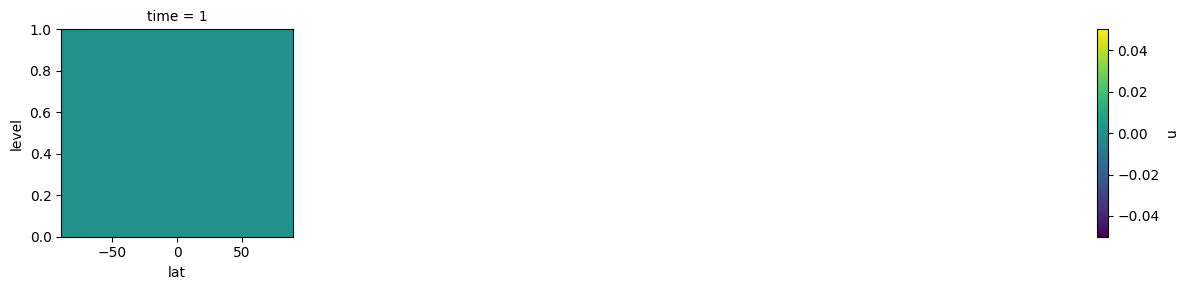

In [9]:
pred_ds['u'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=4)

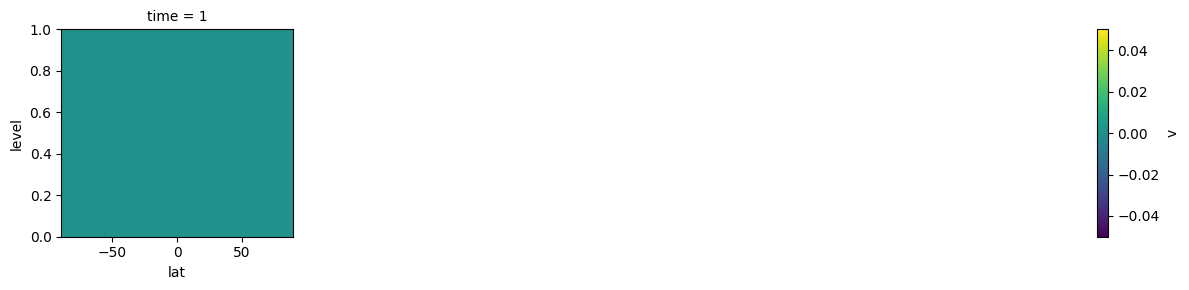

In [10]:
pred_ds['v'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=4)

In [11]:
pred_ds['temperature'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=4)

ValueError: 'lon' not found in array dimensions ('time', 'level', 'longitudinal_mode', 'total_wavenumber')

In [ ]:
pred_ds['specific_humidity'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=4)

In [ ]:
pred_ds['specific_humidity'].isel(level=0).plot(x='lon', y='lat', col='time', col_wrap=4)